In [1]:
%matplotlib inline

# import statements
import numpy as np
import matplotlib.pyplot as plt #for figures
from mpl_toolkits.basemap import Basemap #to render maps
import math
import json #to write dict with parameters

import GrowYourIC
from GrowYourIC import positions, geodyn, geodyn_trg, geodyn_static, plot_data, data

plt.rcParams['figure.figsize'] = (8.0, 3.0) #size of figures
cm = plt.cm.get_cmap('viridis')
cm2 = plt.cm.get_cmap('winter')

/Users/marine/.python-eggs/GrowYourIC-0.5-py3.5.egg-tmp/GrowYourIC/data/CM2008_data.mat


In [2]:
age_ic_dim = 1e9 #in years
rICB_dim = 1221. #in km

translation_velocity_dim = 4.e-10
time_translation = rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)
maxAge = 2.*time_translation/1e6

units = None #we give them already dimensionless parameters. 
rICB = 1.
age_ic = 1.
omega = 0.
#omega_2_dim = 0.45 #degree/Myears
#omega_2 = omega_2_dim*np.pi/180*age_ic_dim*1e-6
#0.5*np.pi/200e6*age_ic_dim#0.5*np.pi #0. #0.5*np.pi/200e6*age_ic_dim# 0.#0.5*np.pi#0.#0.5*np.pi/200e6*age_ic_dim #0. #-0.5*np.pi # Rotation rates has to be in ]-np.pi, np.pi[

velocity_amplitude = translation_velocity_dim*age_ic_dim*np.pi*1e7/rICB_dim/1e3
velocity_center = [0., 100.]#center of the eastern hemisphere
center = [0,-80] #center of the western hemisphere
velocity = geodyn_trg.translation_velocity(velocity_center, velocity_amplitude)
exponent_growth = 0.1

proxy_type = "age"#"growth rate"
proxy_name = "age (Myears)" #growth rate (km/Myears)"
proxy_lim = [0, maxAge] #or None

print("=== Modele 1 ===")
print("The translation recycles the inner core material in {0:.2e} million years.".format(maxAge))
print("Translation velocity is {0:.2e} km/years, {1:.2}.".format(translation_velocity_dim*np.pi*1e7/1e3, velocity_amplitude))
print("Rotation rate is {0:.2e} degree per Myears, {1:.2e}.".format(omega, omega))
print("===")


geodynModel = geodyn_trg.TranslationGrowthRotation() #can do all the models presented in the paper
parameters = dict({'units': units,
              'rICB': rICB, 
              'tau_ic':age_ic,
              'vt': velocity,
              'exponent_growth': exponent_growth,
              'omega': omega,
              'proxy_type': proxy_type})
geodynModel.set_parameters(parameters)
geodynModel.define_units()


=== Modele 1 ===
The translation recycles the inner core material in 1.94e+02 million years.
Translation velocity is 1.26e-05 km/years, 1e+01.
Rotation rate is 0.00e+00 degree per Myears, 0.00e+00.
===


In [3]:
## real data set
data_set = data.SeismicFromFile("../GrowYourIC/data/WD11.dat")
data_set.method = "bt_point"
proxy2 = geodyn.evaluate_proxy(data_set, geodynModel, proxy_type=proxy_type, verbose=False)

# random data set
data_set_random = data.RandomData(3000)
data_set_random.method = "bt_point"
proxy_random = geodyn.evaluate_proxy(data_set_random, geodynModel, proxy_type=proxy_type, verbose=False)
    

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model is Translation, Rotation and Growth
= Proxy is age
= Data set is Data set from Waszek and Deuss 2011
= Proxy is evaluated for bt_point
= Number of points to examine: 3184


/usr/local/lib/python3.5/site-packages/scipy/integrate/_ode.py:1095: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


===
===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model is Translation, Rotation and Growth
= Proxy is age
= Data set is Random repartition of data, between 0 and 100km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 3000
===


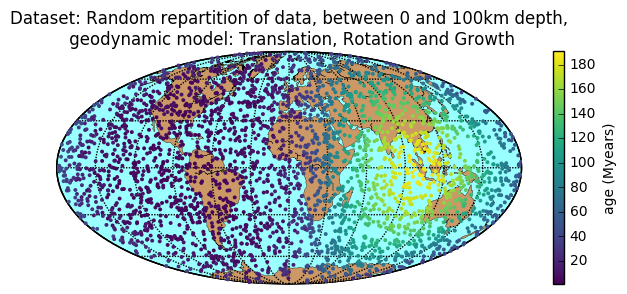

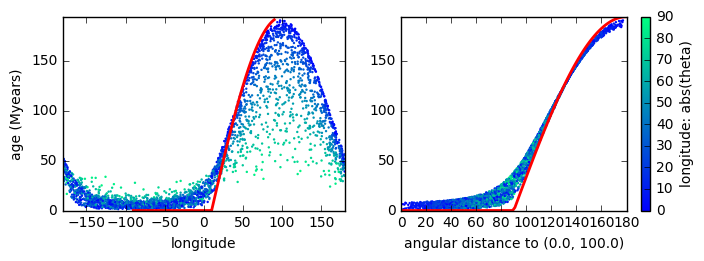

In [4]:
r, t, p = data_set_random.extract_rtp("bottom_turning_point")
dist = positions.angular_distance_to_point(t, p, *center)

## map
m, fig = plot_data.setting_map() 
x, y = m(p, t)
sc = m.scatter(x, y, c=proxy_random,s=8, zorder=10, cmap=cm, edgecolors='none')
plt.title("Dataset: {},\n geodynamic model: {}".format(data_set_random.name, geodynModel.name))
cbar = plt.colorbar(sc)
cbar.set_label(proxy_name)
#fig.savefig(fig_name+data_set_random.shortname+"_map.pdf", bbox_inches='tight')

## phi and distance plots
fig, ax = plt.subplots(1,2, figsize=(8.0, 2.5))
sc1 = ax[0].scatter(p, proxy_random, c=abs(t),s=3, cmap=cm2, vmin =-0, vmax =90, linewidth=0)
phi = np.linspace(-180,180, 50)
ax[0].set_xlabel("longitude")
ax[0].set_ylabel(proxy_name)
if proxy_lim is not None:
    ax[0].set_ylim(proxy_lim)
sc2 = ax[1].scatter(dist, proxy_random, c=abs(t), cmap=cm2, vmin=-0, vmax =90, s=3, linewidth=0)
ax[1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
phi = np.linspace(-90,90, 100)
if proxy_type == "age":
    analytic_equator = np.maximum(2*np.sin((phi-10)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
    ax[0].plot(phi,analytic_equator, 'r', linewidth=2)
    analytic_equator = np.maximum(2*np.sin((-phi)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
    ax[1].plot(90-phi,analytic_equator, 'r', linewidth=2)
ax[1].set_xlim([0,180])
ax[0].set_xlim([-180,180])
cbar = fig.colorbar(sc1)
cbar.set_label("longitude: abs(theta)")
if proxy_lim is not None:
    ax[1].set_ylim(proxy_lim)


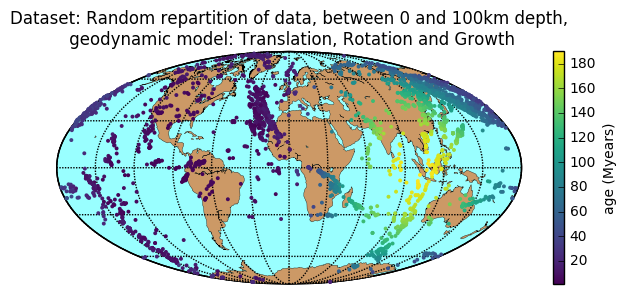

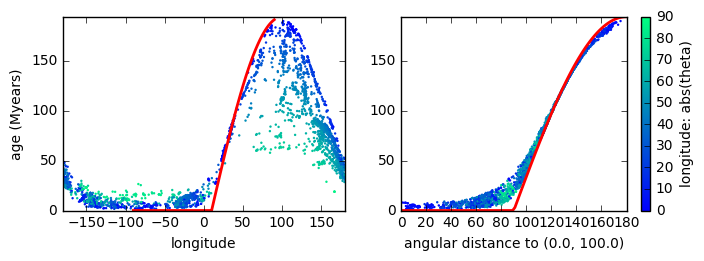

In [5]:
r, t, p = data_set.extract_rtp("bottom_turning_point")
dist = positions.angular_distance_to_point(t, p, *center)

## map
m, fig = plot_data.setting_map() 
x, y = m(p, t)
sc = m.scatter(x, y, c=proxy2,s=8, zorder=10, cmap=cm, edgecolors='none')
plt.title("Dataset: {},\n geodynamic model: {}".format(data_set_random.name, geodynModel.name))
cbar = plt.colorbar(sc)
cbar.set_label(proxy_name)
#fig.savefig(fig_name+data_set_random.shortname+"_map.pdf", bbox_inches='tight')

## phi and distance plots
fig, ax = plt.subplots(1,2, figsize=(8.0, 2.5))
sc1 = ax[0].scatter(p, proxy2, c=abs(t),s=3, cmap=cm2, vmin =-0, vmax =90, linewidth=0)
phi = np.linspace(-180,180, 50)
ax[0].set_xlabel("longitude")
ax[0].set_ylabel(proxy_name)
if proxy_lim is not None:
    ax[0].set_ylim(proxy_lim)
sc2 = ax[1].scatter(dist, proxy2, c=abs(t), cmap=cm2, vmin=-0, vmax =90, s=3, linewidth=0)
ax[1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
phi = np.linspace(-90,90, 100)
if proxy_type == "age":
    analytic_equator = np.maximum(2*np.sin((phi-10)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
    ax[0].plot(phi,analytic_equator, 'r', linewidth=2)
    analytic_equator = np.maximum(2*np.sin((-phi)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
    ax[1].plot(90-phi,analytic_equator, 'r', linewidth=2)
ax[1].set_xlim([0,180])
ax[0].set_xlim([-180,180])
cbar = fig.colorbar(sc1)
cbar.set_label("longitude: abs(theta)")
if proxy_lim is not None:
    ax[1].set_ylim(proxy_lim)
